## Linking banking transactions

This example shows how to perform a one-to-one link on banking transactions.  

The data is fake data, and was generated has the following features:

- Money shows up in the destination account with some time delay
- The amount sent and the amount received are not always the same - there are hidden fees and foreign exchange effects
- The memo is sometimes truncated and content is sometimes missing

Since each origin payment should end up in the destination account, the `probability_two_random_records_match` of the model is known.

In [1]:
# Use arrow to read in data to ensure date types are correct
from pyarrow import parquet as pq
from splink.duckdb.duckdb_linker import DuckDBLinker
import altair as alt
alt.renderers.enable('mimetype')

df_origin = pq.read_table("./data/transactions_left.parquet")
df_origin = df_origin.slice(length=1_000)
df_destination = pq.read_table("./data/transactions_right.parquet")
df_destination = df_destination.slice(length=1_000)
f"There are {df_origin.num_rows:,.0f} records to match"

'There are 1,000 records to match'

In [2]:
# Some sample records
df_origin.to_pandas().head(2)

,ground_truth,memo,transaction_date,amount,unique_id
0,0,MATTHIAS C paym,2022-03-28,36.36,0
1,1,M CORVINUS dona,2022-02-14,221.91,1


In the following chart, we can see this is a challenging dataset to link:
- There are only 151 distinct transaction dates, with strong skew
- Some 'memos' are used multiple times (up to 48 times)
- There is strong skew in the 'amount' column, with 1,400 transactions of around 60.00

In [3]:
# Simple settings just for exploratory analysis
settings = {"link_type": "link_only"}
linker = DuckDBLinker([df_origin, df_destination], settings,input_table_aliases=["__ori", "_dest"])
linker.profile_columns(["transaction_date", "memo", "round(amount/5, 0)*5"])

<VegaLite 4 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/troubleshooting.html


In [4]:
# Design blocking rules that allow for differences in transaction date and amounts

blocking_rule_date_1 = """
    strftime(l.transaction_date, '%Y%m') = strftime(r.transaction_date, '%Y%m')
    and substr(l.memo, 1,3) = substr(r.memo,1,3)
    and l.amount/r.amount > 0.7   and l.amount/r.amount < 1.3
"""

# Offset by half a month to ensure we capture case when the dates are e.g. 31st Jan and 1st Feb
blocking_rule_date_2 = """
    strftime(l.transaction_date+15, '%Y%m') = strftime(r.transaction_date, '%Y%m')
    and substr(l.memo, 1,3) = substr(r.memo,1,3)
    and l.amount/r.amount > 0.7   and l.amount/r.amount < 1.3
"""

blocking_rule_memo = """
substr(l.memo,1,9) = substr(r.memo,1,9)
"""

blocking_rule_amount_1 = """
round(l.amount/2,0)*2 = round(r.amount/2,0)*2 and yearweek(r.transaction_date) = yearweek(l.transaction_date)
"""

blocking_rule_amount_2 = """
round(l.amount/2,0)*2 = round((r.amount+1)/2,0)*2 and yearweek(r.transaction_date) = yearweek(l.transaction_date + 4)
"""

blocking_rule_cheat = """
l.unique_id = r.unique_id
"""


linker.cumulative_num_comparisons_from_blocking_rules_chart(
    [
        blocking_rule_date_1,
        blocking_rule_date_2,
        blocking_rule_memo,
        blocking_rule_amount_1,
        blocking_rule_amount_2,
        blocking_rule_cheat,
    ]
)

<VegaLite 4 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/troubleshooting.html


In [17]:
# Full settings for linking model
import splink.duckdb.duckdb_comparison_level_library as cl

comparison_amount = {
    "output_column_name": "amount",
    "comparison_levels": [
        cl.null_level("amount"),
        cl.exact_match_level("amount"),
        cl.percentage_difference_level("amount",0.01),
        cl.percentage_difference_level("amount",0.03),
        cl.percentage_difference_level("amount",0.1),
        cl.percentage_difference_level("amount",0.3),
        cl.else_level()
    ],
    "comparison_description": "Amount percentage difference",
}


from splink.duckdb import duckdb_comparison_library as cl

settings = {
    "link_type": "link_only",
    "probability_two_random_records_match": 1 / len(df_origin),
    "blocking_rules_to_generate_predictions": [
        blocking_rule_date_1,
        blocking_rule_date_2,
        blocking_rule_memo,
        blocking_rule_amount_1,
        blocking_rule_amount_2,
        blocking_rule_cheat
    ],
    "comparisons": [
        comparison_amount,
        cl.jaccard_at_thresholds(
            "memo", [0.9, 0.7]
        ),
        cl.datediff_at_thresholds("transaction_date", 
                                date_thresholds = [1, 4, 10, 30],
                                date_metrics = ["day", "day", "day", "day"],
                                include_exact_match_level=False
                                )
    ],
    "retain_intermediate_calculation_columns": True,
    "retain_matching_columns": True,
}

In [18]:
linker = DuckDBLinker([df_origin, df_destination], settings,input_table_aliases=["__ori", "_dest"])

In [19]:
linker.estimate_u_using_random_sampling(max_pairs=1e6)

----- Estimating u probabilities using random sampling -----
/Users/rosskennedy/splink_demos/venv/lib/python3.9/site-packages/ipykernel/comm/comm.py:79: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  warn(
/Users/rosskennedy/splink_demos/venv/lib/python3.9/site-packages/ipykernel/comm/comm.py:79: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  warn(
/Users/rosskennedy/splink_demos/venv/lib/python3.9/site-packages/ipykernel/comm/comm.py:79: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  warn(


FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))


Estimated u probabilities using random sampling

Your model is not yet fully trained. Missing estimates for:
    - amount (no m values are trained).
    - memo (no m values are trained).
    - transaction_date (no m values are trained).


In [20]:
linker.estimate_parameters_using_expectation_maximisation("l.memo = r.memo")


----- Starting EM training session -----

Estimating the m probabilities of the model by blocking on:
l.memo = r.memo

Parameter estimates will be made for the following comparison(s):
    - amount
    - transaction_date

Parameter estimates cannot be made for the following comparison(s) since they are used in the blocking rules: 
    - memo

Iteration 1: Largest change in params was -0.558 in the m_probability of amount, level `Exact match`
Iteration 2: Largest change in params was -0.213 in the m_probability of transaction_date, level `Within 1 day`
Iteration 3: Largest change in params was 0.0138 in probability_two_random_records_match
Iteration 4: Largest change in params was 0.00099 in the m_probability of transaction_date, level `Within 30 days`
Iteration 5: Largest change in params was 0.000107 in the m_probability of transaction_date, level `Within 30 days`
Iteration 6: Largest change in params was -8.04e-05 in the m_probability of amount, level `< 30.00% diff`

EM converged a

<EMTrainingSession, blocking on l.memo = r.memo, deactivating comparisons memo>

In [21]:
session = linker.estimate_parameters_using_expectation_maximisation("l.amount = r.amount")


----- Starting EM training session -----

Estimating the m probabilities of the model by blocking on:
l.amount = r.amount

Parameter estimates will be made for the following comparison(s):
    - memo
    - transaction_date

Parameter estimates cannot be made for the following comparison(s) since they are used in the blocking rules: 
    - amount

Iteration 1: Largest change in params was -0.357 in the m_probability of memo, level `Exact match`
Iteration 2: Largest change in params was 0.131 in the m_probability of memo, level `All other comparisons`
Iteration 3: Largest change in params was 0.103 in probability_two_random_records_match
Iteration 4: Largest change in params was 0.03 in probability_two_random_records_match
Iteration 5: Largest change in params was 0.00814 in probability_two_random_records_match
Iteration 6: Largest change in params was 0.00252 in probability_two_random_records_match
Iteration 7: Largest change in params was 0.00082 in probability_two_random_records_matc

In [22]:
linker.match_weights_chart()

<VegaLite 4 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/troubleshooting.html


In [23]:
df_predict = linker.predict(threshold_match_probability=0.001)

In [24]:
linker.comparison_viewer_dashboard(df_predict,"comparison_viewer_transactions.html", overwrite=True)
from IPython.display import IFrame
IFrame(
    src="./comparison_viewer_transactions.html", width="100%", height=1200
)

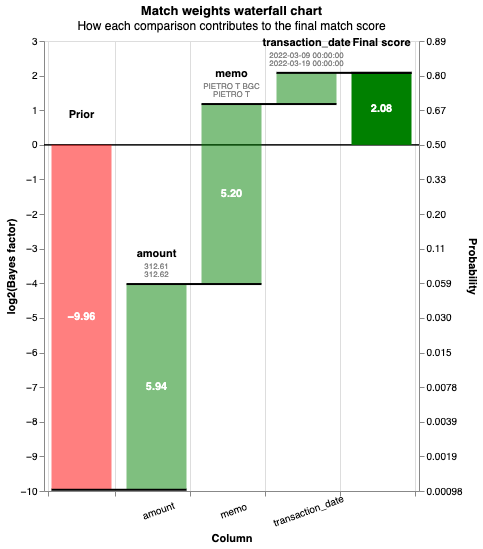

In [13]:
pred_errors =  linker.prediction_errors_from_labels_column("ground_truth", include_false_positives=True, include_false_negatives=False)
linker.waterfall_chart(pred_errors.as_record_dict(limit=5))

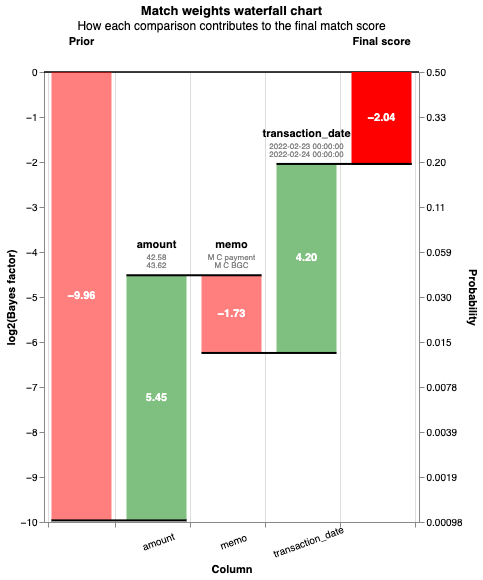

In [14]:
pred_errors =  linker.prediction_errors_from_labels_column("ground_truth", include_false_positives=False, include_false_negatives=True)
linker.waterfall_chart(pred_errors.as_record_dict(limit=5))